In [339]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score
from tensorflow.keras.metrics import AUC, Recall

ModuleNotFoundError: No module named 'tensorflow'

In [340]:
df = pd.read_csv('https://raw.githubusercontent.com/GregaVrbancic/Phishing-Dataset/master/dataset_full.csv')

In [341]:
df2 = df.sample(n=20000, random_state=42)

In [342]:
df2.shape

(20000, 112)

In [264]:
df2.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
29026,4,0,0,0,0,0,0,0,0,0,...,1,3,1,3598,0,-1,0,0,0,0
52848,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3598,1,0,0,0,0,0
3821,2,0,0,0,0,0,0,0,0,0,...,2,2,0,299,1,0,0,0,0,0
74221,4,0,0,0,0,0,0,0,0,0,...,1,3,3,3585,0,0,0,0,0,0
34258,2,0,0,0,0,0,0,0,0,0,...,-1,8,1,-1,0,-1,0,0,0,0


## EDA and Data Check

In [343]:
#no categorical values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 29026 to 56070
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 17.2 MB


In [344]:
#no missing values
assert df2.isna().agg(sum).sum() == 0

In [345]:
#checking for dulplicate rows
df2.duplicated().sum()

184

In [346]:
#dropping duplicate rows
df2 = df2.drop_duplicates(keep=False)

In [347]:
assert df2.duplicated().sum() == 0

In [348]:
df2.shape

(19720, 112)

In [349]:
#moderately imbalanced dataset
df2.phishing.value_counts(normalize=True)

phishing
0    0.651166
1    0.348834
Name: proportion, dtype: float64

## Variance in dataset sections

The entire dataset was devided into the following sections:
- Dataset attributes based on URL
- Dataset attributes based on Domain URL
- Dataset attributes based on URL directory
- Dataset attributes based on URL file name
- Dataset attributes based on URL parameters
- Dataset attributes based on resolving URL and external services

So it makes sense to check how these sections might be different

In [272]:
df2_copy = df2.copy()

In [273]:
#Let's create a separate dataframe for each section
df_url = df2_copy.iloc[:, :19].assign(email_in_url=df2_copy['email_in_url'])
df_domain = df2_copy.iloc[:, 19:40]
df_directory = df2_copy.iloc[:, 40:58]
df_file = df2_copy.iloc[:, 58:76]
df_param = df2_copy.iloc[:, 76:96]
df_external = df2_copy.iloc[:, 97:111]

In [274]:
#We will exclude the last section from comparision becuase it contains data of a different kind
dataframes = [df_url, df_domain, df_directory, df_file, df_param]
df_names = ['URL', 'Domain', 'Directory', 'File', 'Parameter']

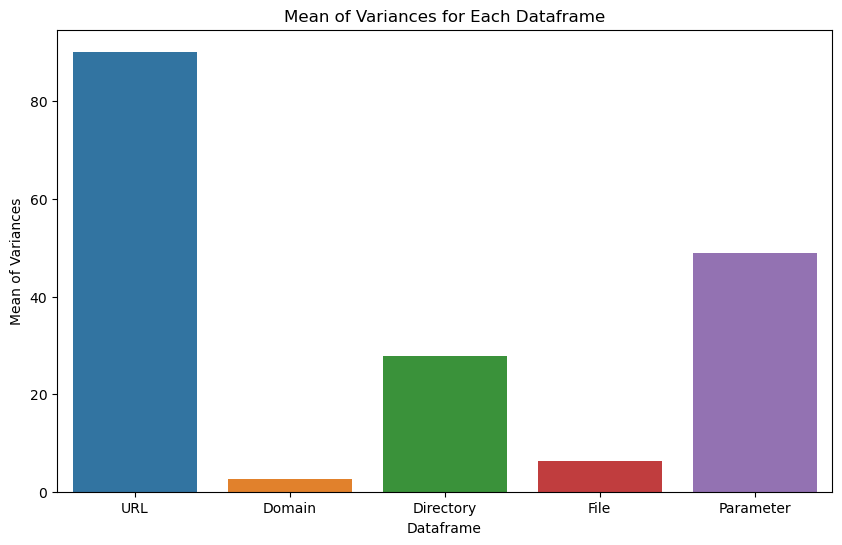

In [275]:
#Let's calculate mean values of variances for all sections and plot the result
results = []
for df2_copy, name in zip(dataframes, df_names):
    result = df2_copy.var().mean()
    results.append({'Dataframe': name, 'Variance Mean': result})
result_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataframe', y='Variance Mean', data=result_df)
plt.title('Mean of Variances for Each Dataframe')
plt.xlabel('Dataframe')
plt.ylabel('Mean of Variances')
plt.show()

In [9]:
#As we can see, the domain section has near zero mean variance which might indicate its less importance

## mutual_info_classif

In [276]:
X = df2.drop('phishing', axis=1)
y = df2['phishing']

In [277]:
mi_scores = mutual_info_classif(X, y)

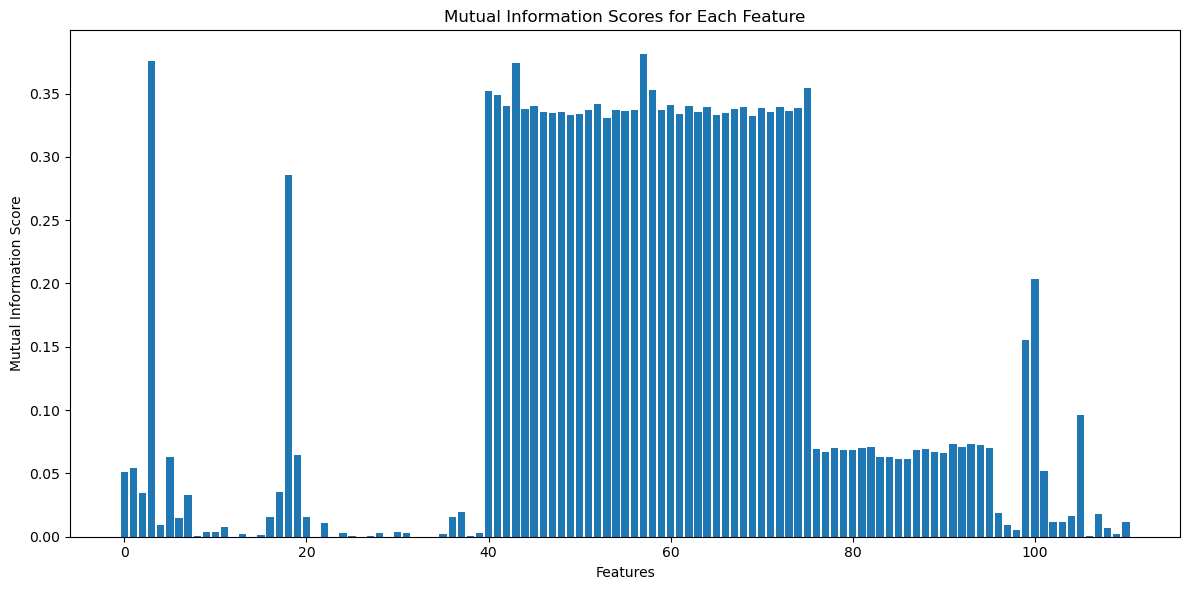

In [278]:
# Create a bar plot of mutual information scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Each Feature')
#plt.xticks(range(len(mi_scores)), X.columns, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [279]:
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False).reset_index(drop=True)
print("\nFeatures ranked by Mutual Information Score:")
print(mi_df)


Features ranked by Mutual Information Score:
                     Feature  MI_Score
0           directory_length  0.380873
1              qty_slash_url  0.375451
2        qty_slash_directory  0.374470
3                file_length  0.354033
4               qty_dot_file  0.352593
..                       ...       ...
106  qty_questionmark_domain  0.000000
107        qty_dollar_domain  0.000000
108     qty_underline_domain  0.000000
109          qty_hashtag_url  0.000000
110             qty_plus_url  0.000000

[111 rows x 2 columns]


In [280]:
mi_df.query('MI_Score > 0.01')

,Feature,MI_Score
0,directory_length,0.380873
1,qty_slash_url,0.375451
2,qty_slash_directory,0.374470
3,file_length,0.354033
4,qty_dot_file,0.352593
...,...,...
76,qty_at_url,0.014733
77,url_shortened,0.011858
78,qty_ip_resolved,0.011588
79,qty_nameservers,0.011292


([], [])

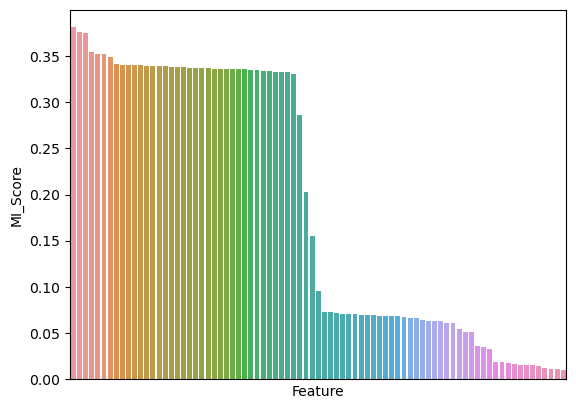

In [281]:
sns.barplot(x='Feature', y='MI_Score', data=mi_df.query('MI_Score > 0.01'))
plt.xticks([])

In [282]:
mi_df.query('MI_Score < 0.01')

,Feature,MI_Score
81,qty_questionmark_url,0.009552
82,time_response,0.009321
83,qty_comma_url,0.007531
84,url_google_index,0.006987
85,domain_spf,0.005655
86,qty_tilde_url,0.003981
87,qty_comma_domain,0.003407
88,qty_space_url,0.003355
89,qty_space_domain,0.003061
90,qty_equal_domain,0.003002


## Multicollinearity

**The dataset has a high degree of multicollinearity, however, we will not do anything about it**

In [219]:
corr_matrix = df2.corr()

In [220]:
threshold = 0.8

In [221]:
#Create a mask to ignore self-correlations (diagonal) and lower triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

In [222]:
#Extract pairs of features with correlation greater than the threshold
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   for i, j in zip(*np.where((np.abs(corr_matrix) > threshold) & mask))]

In [223]:
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

In [224]:
high_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature 1    495 non-null    object 
 1   Feature 2    495 non-null    object 
 2   Correlation  495 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.7+ KB


## PCA

In [225]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [227]:
# Apply PCA
# pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [228]:
# Print the number of components selected
# print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 36


## Data prep and removing constant features

In [350]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(labels=['phishing'], axis=1),  
    df2['phishing'], 
    test_size=0.2,
    random_state=0)

In [351]:
X_train.shape

(15776, 111)

In [352]:
sel = VarianceThreshold(threshold=0)

In [353]:
sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [354]:
constant = X_train.columns[~sel.get_support()]
len(constant)

14

In [355]:
# capture non-constant feature names
feat_names = X_train.columns[sel.get_support()]

In [356]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((15776, 97), (3944, 97))

In [357]:
#standard scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PCA

In [358]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep enough components to explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [359]:
# Print the number of components selected
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 36


## About accuracy metric

For this dataset, a false positive will be observed when a model labels a normal site as malicious. A false negative will be observed when a model labels a malicious site. False negatives are more dangerous as a user will trust a malicious site. Therefore, we will be using recall score.

## Aplying models

**Dummy classifier**

In [360]:
#We will use a sklearn dummy classifier to establish a baseline
dummy_clf = DummyClassifier(strategy="prior")

In [361]:
dummy_clf.fit(X_train_scaled, y_train)

DummyClassifier()

In [362]:
y_pred_test = dummy_clf.predict(X_test_scaled)
y_pred_train = dummy_clf.predict(X_train_scaled)

In [363]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false negative rate or 
#recall score
np.unique(y_pred_test)

array([0])

In [364]:
auc_roc_test_dummy = roc_auc_score(y_test, y_pred_test)
auc_roc_train_dummy = roc_auc_score(y_train, y_pred_train)
print("Test set AUC-ROC score: ", round(auc_roc_test_dummy, 3))
print("Train set AUC-ROC score: ", round(auc_roc_train_dummy, 3))

Test set AUC-ROC score:  0.5
Train set AUC-ROC score:  0.5


In [248]:
#0.5 indicates random guessing

In [365]:
#we can look at the classification report to confirm that
report = classification_report(y_test, y_pred_test, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.66      1.00      0.79      2584
           1       0.00      0.00      0.00      1360

    accuracy                           0.66      3944
   macro avg       0.33      0.50      0.40      3944
weighted avg       0.43      0.66      0.52      3944



In [366]:
#function to calculate scores
def calculate_scores(model):
    recall_test = recall_score(y_test, model.predict(X_test_scaled))
    recall_train = recall_score(y_train, model.predict(X_train_scaled))
    
    auc_roc_test = roc_auc_score(y_test, model.predict(X_test_scaled))
    auc_roc_train = roc_auc_score(y_train, model.predict(X_train_scaled))
    
    print("Test set recall score: ", round(recall_test, 3))
    print("Train set recall score: ", round(recall_train, 3))
    print("Test set AUC-ROC score: ", round(auc_roc_test, 3))
    print("Train set AUC-ROC score: ", round(auc_roc_train, 3))
    
    return recall_test, recall_train, auc_roc_test, auc_roc_test 

**Logistic regression**

In [367]:
log_reg = LogisticRegression(max_iter=10000)

In [368]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [369]:
calculate_scores(log_reg)

Test set recall score:  0.913
Train set recall score:  0.916
Test set AUC-ROC score:  0.925
Train set AUC-ROC score:  0.927


(0.913235294117647, 0.916470375067947, 0.9252708978328172, 0.9252708978328172)

**KNN**

In [370]:
knn = KNeighborsClassifier()

In [371]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [372]:
calculate_scores(knn)

Test set recall score:  0.927
Train set recall score:  0.937
Test set AUC-ROC score:  0.938
Train set AUC-ROC score:  0.951


(0.9272058823529412, 0.9373074832397174, 0.938061145510836, 0.938061145510836)

**Decision Tree**

In [373]:
decision_tree = DecisionTreeClassifier()

In [374]:
decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [375]:
calculate_scores(decision_tree)

Test set recall score:  0.911
Train set recall score:  1.0
Test set AUC-ROC score:  0.929
Train set AUC-ROC score:  1.0


(0.9110294117647059,
 0.9998188077550281,
 0.9286184210526316,
 0.9286184210526316)

**SVM**

In [376]:
svc = SVC()

In [377]:
svc.fit(X_train_scaled, y_train)

SVC()

In [378]:
calculate_scores(svc)

Test set recall score:  0.934
Train set recall score:  0.934
Test set AUC-ROC score:  0.938
Train set AUC-ROC score:  0.94


(0.9338235294117647,
 0.9340460228302229,
 0.9378869969040248,
 0.9378869969040248)

**Random forrest**

In [379]:
rf = RandomForestClassifier(n_estimators=300, random_state=0)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=300, random_state=0)

In [380]:
calculate_scores(rf)

Test set recall score:  0.955
Train set recall score:  1.0
Test set AUC-ROC score:  0.961
Train set AUC-ROC score:  1.0


(0.9551470588235295,
 0.9998188077550281,
 0.9609326625386996,
 0.9609326625386996)

**Random forrest PCA**

In [381]:
rf_PCA = RandomForestClassifier(n_estimators=300, random_state=42)
rf_PCA.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [382]:
y_pred_PCA = rf_PCA.predict(X_test_pca)

In [383]:
recall = recall_score(y_test, y_pred_PCA)
print(f"\nRecall Score: {recall:.4f}")


Recall Score: 0.9471


**Recursive feature elimination with Random forrest**

In [384]:
#restoring dataframe
X_train_scaled = pd.DataFrame(X_train, columns=feat_names)
X_test_scaled = pd.DataFrame(X_test, columns=feat_names)

In [385]:
recall_scores = {}

In [386]:
for n_features in range(1, X_train_scaled.shape[1] + 1):
    print(f"Selecting {n_features} features")
    
    # RFE with the model
    sel_ = RFE(RandomForestClassifier(n_estimators=300, random_state=0), n_features_to_select=n_features)
    sel_.fit(X_train_scaled, y_train)
    
    # Select the features
    selected_feat = X_train_scaled.columns[(sel_.get_support())]
    X_train_selected = X_train_scaled[selected_feat]
    X_test_selected = X_test_scaled[selected_feat]
    
    # Train the Random Forest model
    rf1 = RandomForestClassifier(n_estimators=300, random_state=0)
    rf1.fit(X_train_selected, y_train)
    
    # Predict and calculate recall score
    y_pred_test_rf_sel = rf1.predict(X_test_selected)
    recall_test_rf_selected = recall_score(y_test, y_pred_test_rf_sel)
    
    # Store the recall score and number of features in the dictionary
    recall_scores[n_features] = recall_test_rf_selected
    print(f"Recall score for {n_features} features: {recall_test_rf_selected}")

Selecting 1 features


KeyboardInterrupt: 

<Axes: >

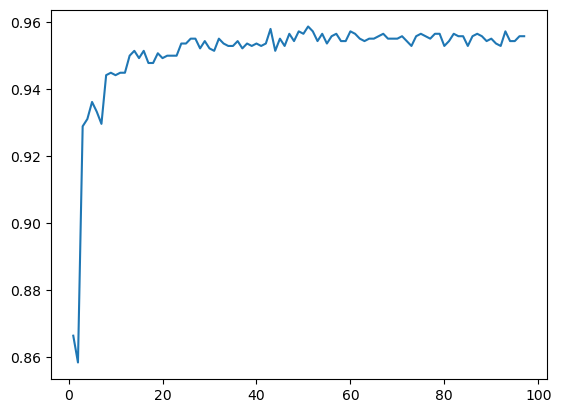

In [316]:
sns.lineplot(recall_scores)

In [317]:
sorted_dict = dict(sorted(recall_scores.items(), key=lambda item: item[1], reverse=True))
next(iter(sorted_dict.items()))

(51, 0.9585755813953488)

In [329]:
rfe1 = RFE(RandomForestClassifier(n_estimators=300, random_state=0), n_features_to_select=51)

In [330]:
rfe1.fit(X_train_scaled, y_train)

RFE(estimator=RandomForestClassifier(n_estimators=300, random_state=0),
    n_features_to_select=51)

In [331]:
selected_feat = X_train_scaled.columns[(rfe1.get_support())]
len(selected_feat)

51

In [332]:
selected_feat

Index(['qty_dot_url', 'qty_hyphen_url', 'qty_slash_url', 'length_url',
       'qty_dot_domain', 'qty_vowels_domain', 'domain_length',
       'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_questionmark_directory', 'qty_at_directory',
       'qty_and_directory', 'qty_space_directory', 'qty_tilde_directory',
       'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory',
       'qty_hashtag_directory', 'qty_dollar_directory',
       'qty_percent_directory', 'directory_length', 'qty_dot_file',
       'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file',
       'qty_questionmark_file', 'qty_equal_file', 'qty_at_file',
       'qty_and_file', 'qty_exclamation_file', 'qty_tilde_file',
       'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file',
       'qty_hashtag_file', 'qty_dollar_file', 'qty_percent_file',
       'file_length', 'params_length', 'time_response', 'asn_ip',
       'time_domain_activation', 'time_d

In [333]:
X_train_selected = X_train_scaled[selected_feat]
X_test_selected = X_test_scaled[selected_feat]

**Random forrest with 51 features**

In [334]:
rf2 = RandomForestClassifier(n_estimators=300, random_state=0)
rf2.fit(X_train_selected, y_train)

RandomForestClassifier(n_estimators=300, random_state=0)

In [335]:
y_pred_test_rf_selected = rf2.predict(X_test_selected)
y_pred_train_rf_selected = rf2.predict(X_train_selected)

In [336]:
recall_test_rf_selected = recall_score(y_test, y_pred_test_rf_selected)
recall_train_rf_selected = recall_score(y_train, y_pred_train_rf_selected)

In [337]:
print("Test set precision score: ", round(recall_test_rf_selected, 3))
print("Train set precision score: ", round(recall_train_rf_selected, 3))

Test set precision score:  0.959
Train set precision score:  1.0


**XG Boost**

In [309]:
xg = xgb.XGBClassifier(seed=123)

In [310]:
xg.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [311]:
calculate_scores(xg)

Test set recall score:  0.944
Train set recall score:  0.992
Test set AUC-ROC score:  0.955
Train set AUC-ROC score:  0.994


(0.9440406976744186,
 0.9918226421951662,
 0.9546916884010721,
 0.9546916884010721)

## Tuning the model